# Keras Transfer Learning Example

We will take a look at a popular pretrained neural network for Keras. The following sites, among others, can be great starting points to find pretrained models for use in your projects:

* [Bioimage Model Zoo](https://bioimage.io/)
* [TensorFlow Model Zoo](https://modelzoo.co/)
* [Papers with Code](https://paperswithcode.com/)
* [ModelZoo](https://modelzoo.co/)
* [Keras Applications](https://keras.io/applications/)


## Transfering Computer Vision

This section will show you how to obtain a pretrained model for computer vision - Xception - and train just the output layer. Additionally, once we train the output layer, we will fine-tune the entire network by training all weights  by applying a low learning rate.

## The Kaggle Cats vs. Dogs Dataset

We will train a neural network to recognize cats and dogs for this example. The [cats and dogs dataset](https://www.kaggle.com/c/dogs-vs-cats) comes from a classic Kaggle competition. This notebook is based on a tutorial provided by [Francois Chollet](https://keras.io/guides/transfer_learning/), one of the creators of Keras. It was converted to notbook format by Jeff Heaton and contains some modifications I introduced to his notebook to fit with this course.

We begin by downloading the dataset from Keras. We do not need the entire dataset to achieve high accuracy. Using a portion also speeds up training. We will use 40% of the original training data (25,000 images) for training and 10% for validation.

The dogs and cats dataset is relatively large and will not easily fit into a less than 12GB system, such as Colab. Because of this memory size, we must take additional steps to handle the data. Rather than loading the dataset as a Numpy array, as we have done previously, we will load it as a prefetched dataset so that only the portions of the dataset currently needed are in RAM.

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

train_ds, validation_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]"],
    as_supervised=True,  # Include labels
)

num_train = tf.data.experimental.cardinality(train_ds)
num_test = tf.data.experimental.cardinality(validation_ds)

print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_test}")

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326


## Looking at the Data and Augmentations

We begin by displaying several of the images from this dataset. The labels are above each image. As can be seen from the images below, 1 indicates a dog, and 0 indicates a cat.

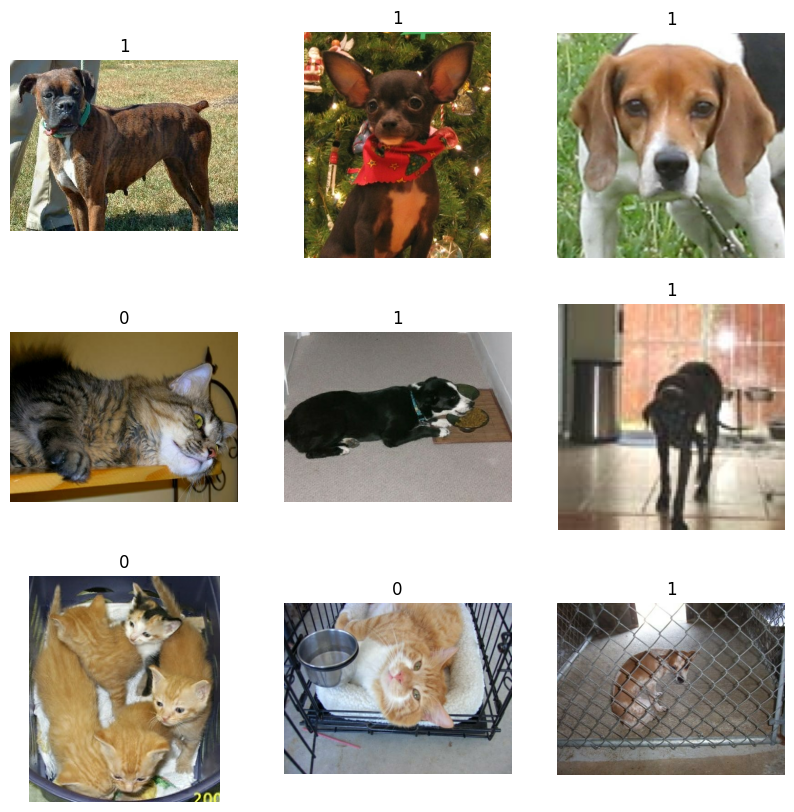

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

Upon examining the above images, another problem becomes evident. The images are of various sizes. We will standardize all images to 190x190 with the following code.

In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: \
                                  (tf.image.resize(x, size), y))

We will batch the data and use caching and prefetching to optimize loading speed.

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache() \
    .batch(batch_size).prefetch(buffer_size=10)

Augmentation is a powerful computer vision technique that increases the amount of training data available to your model by altering the images in the training data. To use augmentation, we will allow horizontal flips of the images. A horizontal flip makes much more sense for cats and dogs in the real world than a vertical flip. How often do you see upside-down dogs or cats? We also include a limited degree of rotation.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

The following code allows us to visualize the augmentation.

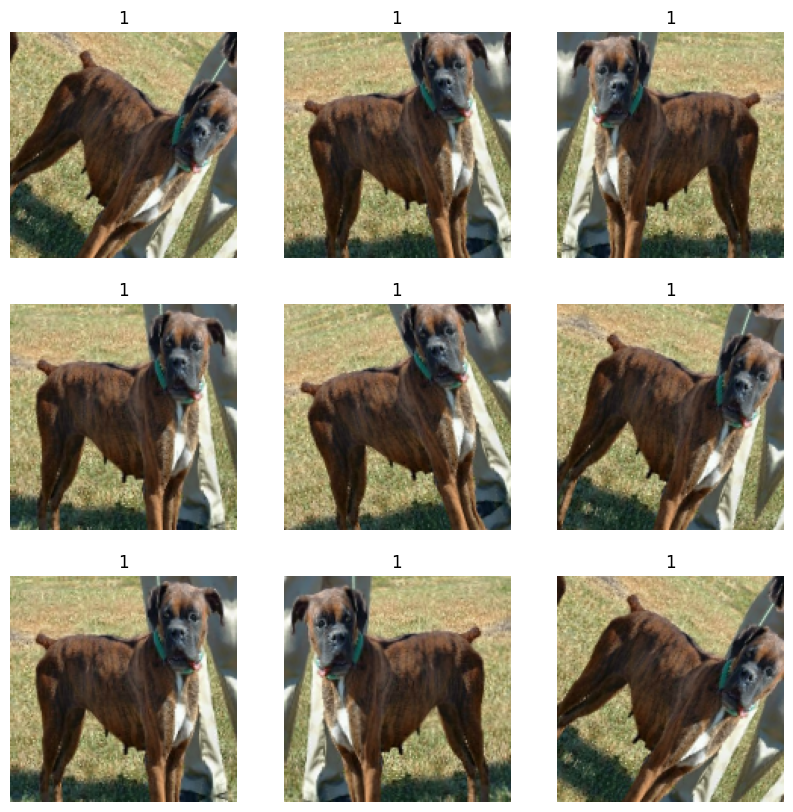

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## Create a Network and Transfer Weights

We are now ready to create our new neural network with transferred weights. We will transfer the weights from an Xception neural network that contains weights trained for imagenet. We load the existing Xception neural network with **keras.applications**. There is quite a bit going on with the loading of the **base_model**, so we will examine this call piece by piece.

The base Xception neural network accepts an image of 299x299. However, we would like to use 150x150. It turns out that it is relatively easy to overcome this difference. Convolutional neural networks move a kernel across an image tensor as they scan. Keras defines the number of weights by the size of the layer's kernel, not the image that the kernel scans. As a result, we can discard the old input layer and recreate an input layer consistent with our desired image size. We specify **include_top** as false and specify our input shape.

We freeze the base model so that the model will not update existing weights as training occurs. We create the new input layer that consists of 150x150 by 3 RGB color components. These RGB components are integer numbers between 0 and 255. Neural networks deal better with floating-point numbers when you distribute them around zero. To accomplish this neural network advantage, we normalize each RGB component to between -1 and 1.

The batch normalization layers do require special consideration. We need to keep these layers in inference mode when we unfreeze the base model for fine-tuning. To do this, we make sure that the base model is running in inference mode here.


In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers.
# We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning,
# so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

Next, we compile and fit the model. The fitting will use the Adam optimizer; because we are performing binary classification, we use the binary cross-entropy loss function.

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 37s 97ms/step - binary_accuracy: 0.8976 - loss: 0.2225 - val_binary_accuracy: 0.9695 - val_loss: 0.0812
Epoch 2/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step - binary_accuracy: 0.9434 - loss: 0.1277 - val_binary_accuracy: 0.9703 - val_loss: 0.0772
Epoch 3/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - binary_accuracy: 0.9544 - loss: 0.1126 - val_binary_accuracy: 0.9721 - val_loss: 0.0749
Epoch 4/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - binary_accuracy: 0.9530 - loss: 0.1157 - val_binary_accuracy: 0.9712 - val_loss: 0.0746
Epoch 5/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - binary_accuracy: 0.9567 - loss: 0.1042 - val_binary_accuracy: 0.9682 - val_loss: 0.0789
Epoch 6/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - binary_accuracy: 0.9547 - loss: 0.1093 - val_binary_accuracy: 0.9695 - val_loss: 0.0757
Epoch 7/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - binary_accuracy: 0.9550 - loss: 0.1050 - val_binary_accuracy: 0.9686 - val_loss:

The training above shows that the validation accuracy reaches the mid 90% range. This accuracy is good; however, we can do better.   

## Fine-Tune the Model

Finally, we will fine-tune the model. First, we set all weights to trainable and then train the neural network with a low learning rate (1e-5). This fine-tuning results in an accuracy in the upper 90% range. The fine-tuning allows all weights in the neural network to adjust slightly to optimize for the dogs/cats data.

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 4,100 (16.02 KB)

Epoch 1/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 126s 337ms/step - binary_accuracy: 0.8641 - loss: 0.3006 - val_binary_accuracy: 0.9544 - val_loss: 0.1098
Epoch 2/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 97s 335ms/step - binary_accuracy: 0.9259 - loss: 0.1805 - val_binary_accuracy: 0.9635 - val_loss: 0.0946
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 97s 335ms/step - binary_accuracy: 0.9473 - loss: 0.1275 - val_binary_accuracy: 0.9678 - val_loss: 0.0860
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 97s 334ms/step - binary_accuracy: 0.9603 - loss: 0.1077 - val_binary_accuracy: 0.9695 - val_loss: 0.0819
Epoch 5/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 97s 334ms/step - binary_accuracy: 0.9662 - loss: 0.0837 - val_binary_accuracy: 0.9699 - val_loss: 0.0753
Epoch 6/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 97s 334ms/step - binary_accuracy: 0.9738 - loss: 0.0725 - val_binary_accuracy: 0.9721 - val_loss: 0.0714
Epoch 7/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 97s 334ms/step - binary_accuracy: 0.9757 - loss: 0.0639 - val_binary_accuracy: 0.9742 - v